In [6]:
import sys
import dawis as d
import glob as glob
import os
import numpy as np
import pyregion as pyr
import random
import gc
import h5py
import dawis
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.io import fits
from astropy.visualization import *
from scipy.stats import kurtosis
from power_ratio import *
from datetime import datetime
from photutils.segmentation import SourceCatalog, detect_sources
from photutils.background import Background2D, MedianBackground
import make_results_ERO_noray
import tracemalloc
import matplotlib
import cmasher
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Rectangle
from astropy.stats import sigma_clip, SigmaClip
import subprocess


In [9]:
# Paths, lists & variables
path_data = '/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/'
path_scripts = '/home/aellien/Euclid_ERO/Euclid_ERO_scripts'
path_wavelets = '/home/aellien/Euclid_ERO/wavelets/out11/'
path_plots = '/home/aellien/Euclid_ERO/plots'
path_analysis = '/home/aellien/Euclid_ERO/analysis/'

hdu = fits.open('/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.masked.rot.crop.warp.input.fits')
header = hdu[0].header
oim = hdu[0].data
xs, ys = oim.shape

In [26]:
# Make masks of all objects
hdu1 = fits.open(os.path.join(path_analysis, 'Abell_2390_NISP_mask_all_but_bcg_full_img_H.fits'))
m_all_but_bcg = hdu1[0].data
hdu2 = fits.open(os.path.join(path_analysis, 'Abell_2390_NISP_mask_all_but_clmembers_full_img_H.fits'))
m_all_but_clmembers = hdu2[0].data

m_all = np.copy(m_all_but_bcg.astype(bool))
m_all[np.where((m_all_but_clmembers.astype(bool) == False) & (m_all == True)) ] = False
m_all = m_all.astype(int)

hduo = fits.PrimaryHDU(m_all, header = hdu1[0].header) 
hduo.writeto(os.path.join(path_analysis, 'Abell_2390_NISP_mask_all_full_img_H.fits'))

In [89]:
# Apply mask & inpaint & preprocessing
for infile in glob.glob(os.path.join(path_data, 'Euclid-NISP-?-ERO-Abell2390-LSB.DR3.fits')):
    
    print(infile)
    filt = infile[-28]
    hdu = fits.open(os.path.join(path_data, infile))
    oim, header = hdu[0].data, hdu[0].header
    mask = fits.getdata(os.path.join(path_analysis, 'Abell_2390_NISP_mask_all_full_img_H.fits'))

    # mask
    moim = np.copy(oim)
    moim[~mask.astype(bool)] = np.nan

    # inpaint
    noise_pixels, val_max = dawis.sample_noise(moim, n_sigmas = 3, bins = 300)
    mean, std = np.mean(noise_pixels), np.std(noise_pixels)
    mask = np.zeros(moim.shape)
    mask[ moim < -abs(5 * std) ] = 1.
    mask[np.where(np.isnan(moim) == True)] = 1.
    draws = np.random.normal(mean, std, moim.shape)
    mask *= draws
    moim[ moim < -abs(5 * std) ] = 0.
    moim[ np.where(np.isnan(moim) == True)] = 0.
    moim += mask
    hduo = fits.PrimaryHDU(moim, header = header)
    hduo.writeto(os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.masked.fits'%filt), overwrite = True)

    # rot
    masked = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.masked.fits'%filt)
    rot = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.masked.rot.fits'%filt)
    subprocess.run(['astwarp', '--rotate=295', '-h0', masked, '--output=%s'%rot])

    # crop
    crop = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.masked.rot.crop.fits'%filt)
    subprocess.run(['astcrop', '--mode=wcs', '--center=328.40009,17.699051', '--width=0.75,0.75', '-h1', '--output=%s'%crop, rot])

    # warp
    warp = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.masked.rot.crop.warp.fits'%filt)
    subprocess.run(['astwarp', '--scale=1./4.', '-h1', '--output=%s'%warp, crop])

    # dawis input rdy
    input = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.masked.rot.crop.warp.input.fits'%filt)
    subprocess.run(['astfits', warp, '--copy=1', '--output=%s'%input, '--primaryimghdu'])

print('done')

/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.fits


Warp 0.21 started on Sun Jul 14 12:48:21 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.masked.fits (hdu: 0)
 matrix:
	 0.4226    0.9063    0.0000
	-0.9063    0.4226    0.0000
	 0.0000    0.0000    1.0000
 Output: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.masked.rot.fits
Warp finished in:  18.026429 seconds
Crop 0.21 started on Sun Jul 14 12:48:39 2024
  - Read metadata of 1 dataset.                        0.001318 seconds
  ---- ...SB.DR3.masked.rot.crop.fits created: 1 input.
Crop finished in:  1.197804 seconds
Warp 0.21 started on Sun Jul 14 12:48:40 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.masked.rot.crop.fits (hdu: 1)
 matrix:
	 0.2500    0.0000    0.0000
	 0.0000    0.2500    0.0000
	 0.0000    0.0000    1.0000
 Output: /home/aellien/Eu

Warp 0.21 started on Sun Jul 14 12:49:01 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.masked.fits (hdu: 0)
 matrix:
	 0.4226    0.9063    0.0000
	-0.9063    0.4226    0.0000
	 0.0000    0.0000    1.0000
 Output: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.masked.rot.fits
Warp finished in:  18.481371 seconds
Crop 0.21 started on Sun Jul 14 12:49:20 2024
  - Read metadata of 1 dataset.                        0.000885 seconds
  ---- ...SB.DR3.masked.rot.crop.fits created: 1 input.
Crop finished in:  1.109867 seconds
Warp 0.21 started on Sun Jul 14 12:49:21 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.masked.rot.crop.fits (hdu: 1)
 matrix:
	 0.2500    0.0000    0.0000
	 0.0000    0.2500    0.0000
	 0.0000    0.0000    1.0000
 Output: /home/aellien/Eu

Warp 0.21 started on Sun Jul 14 12:49:42 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.masked.fits (hdu: 0)
 matrix:
	 0.4226    0.9063    0.0000
	-0.9063    0.4226    0.0000
	 0.0000    0.0000    1.0000
 Output: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.masked.rot.fits
Warp finished in:  18.727742 seconds
Crop 0.21 started on Sun Jul 14 12:50:01 2024
  - Read metadata of 1 dataset.                        0.000815 seconds
  ---- ...SB.DR3.masked.rot.crop.fits created: 1 input.
Crop finished in:  1.136072 seconds
Warp 0.21 started on Sun Jul 14 12:50:02 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.masked.rot.crop.fits (hdu: 1)
 matrix:
	 0.2500    0.0000    0.0000
	 0.0000    0.2500    0.0000
	 0.0000    0.0000    1.0000
 Output: /home/aellien/Eu

In [8]:
# Make same image without masking
for infile in glob.glob(os.path.join(path_data, 'Final*.fits')):
    
    print(infile)
    filt = infile[-28]
    hdu = fits.open(os.path.join(path_data, infile))
    oim, header = hdu[0].data, hdu[0].header

    # rot
    rot = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.rot.fits'%filt)
    subprocess.run(['astwarp', '--rotate=295', '-h0', infile, '--output=%s'%rot])

    # crop
    crop = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.rot.crop.fits'%filt)
    subprocess.run(['astcrop', '--mode=wcs', '--center=328.40009,17.699051', '--width=0.75,0.75', '-h1', '--output=%s'%crop, rot])

    # warp
    warp = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.rot.crop.warp.fits'%filt)
    subprocess.run(['astwarp', '--scale=1./4.', '-h1', '--output=%s'%warp, crop])

    # dawis input rdy
    input = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.fits'%filt)
    subprocess.run(['astfits', warp, '--copy=1', '--output=%s'%input, '--primaryimghdu'])

print('done')

/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Final_output_JGM_Abellfinal_psf_sub_Yv1_vC1_v21.fits
Warp 0.21 started on Mon Jul 29 21:22:02 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Final_output_JGM_Abellfinal_psf_sub_Yv1_vC1_v21.fits (hdu: 0)
 matrix:
	 0.4226    0.9063    0.0000
	-0.9063    0.4226    0.0000
	 0.0000    0.0000    1.0000
 Output: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Euclid-NISP-n-ERO-Abell2390-LSB.DR3.rot.fits
Warp finished in:  17.793780 seconds
/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Final_output_JGM_Abellfinal_psf_sub_Jv1_vC1_v21.fits


astcrop: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Euclid-NISP-n-ERO-Abell2390-LSB.DR3.rot.fits (hdu 1): the WCS structure is not recognized or isn't present. Hence the WCS mode cannot be used as input coordinates. You can try with pixel coordinates using '--mode=img'
astwarp: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Euclid-NISP-n-ERO-Abell2390-LSB.DR3.rot.crop.fits: No such file or directory
astfits: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Euclid-NISP-n-ERO-Abell2390-LSB.DR3.rot.crop.warp.fits: No such file or directory


Warp 0.21 started on Mon Jul 29 21:22:20 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Final_output_JGM_Abellfinal_psf_sub_Jv1_vC1_v21.fits (hdu: 0)
 matrix:
	 0.4226    0.9063    0.0000
	-0.9063    0.4226    0.0000
	 0.0000    0.0000    1.0000
 Output: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Euclid-NISP-n-ERO-Abell2390-LSB.DR3.rot.fits
Warp finished in:  17.434752 seconds
/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Final_output_JGM_Abellfinal_psf_sub_Hv1_vC1_v24.fits


astcrop: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Euclid-NISP-n-ERO-Abell2390-LSB.DR3.rot.fits (hdu 1): the WCS structure is not recognized or isn't present. Hence the WCS mode cannot be used as input coordinates. You can try with pixel coordinates using '--mode=img'
astwarp: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Euclid-NISP-n-ERO-Abell2390-LSB.DR3.rot.crop.fits: No such file or directory
astfits: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Euclid-NISP-n-ERO-Abell2390-LSB.DR3.rot.crop.warp.fits: No such file or directory


Warp 0.21 started on Mon Jul 29 21:22:37 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Final_output_JGM_Abellfinal_psf_sub_Hv1_vC1_v24.fits (hdu: 0)
 matrix:
	 0.4226    0.9063    0.0000
	-0.9063    0.4226    0.0000
	 0.0000    0.0000    1.0000
 Output: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Euclid-NISP-n-ERO-Abell2390-LSB.DR3.rot.fits
Warp finished in:  17.519296 seconds
/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Final_output_JGM_Abellfinal_psf_sub_Hv1_Callummock.fits


astcrop: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Euclid-NISP-n-ERO-Abell2390-LSB.DR3.rot.fits (hdu 1): the WCS structure is not recognized or isn't present. Hence the WCS mode cannot be used as input coordinates. You can try with pixel coordinates using '--mode=img'
astwarp: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Euclid-NISP-n-ERO-Abell2390-LSB.DR3.rot.crop.fits: No such file or directory
astfits: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Euclid-NISP-n-ERO-Abell2390-LSB.DR3.rot.crop.warp.fits: No such file or directory


Warp 0.21 started on Mon Jul 29 21:22:55 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Final_output_JGM_Abellfinal_psf_sub_Hv1_Callummock.fits (hdu: 0)
 matrix:
	 0.4226    0.9063    0.0000
	-0.9063    0.4226    0.0000
	 0.0000    0.0000    1.0000
 Output: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Euclid-NISP-_-ERO-Abell2390-LSB.DR3.rot.fits
Warp finished in:  17.127774 seconds
done


astcrop: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Euclid-NISP-_-ERO-Abell2390-LSB.DR3.rot.fits (hdu 1): the WCS structure is not recognized or isn't present. Hence the WCS mode cannot be used as input coordinates. You can try with pixel coordinates using '--mode=img'
astwarp: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Euclid-NISP-_-ERO-Abell2390-LSB.DR3.rot.crop.fits: No such file or directory
astfits: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Euclid-NISP-_-ERO-Abell2390-LSB.DR3.rot.crop.warp.fits: No such file or directory


In [7]:
nfp = os.path.join(path_wavelets, 'Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.')
opath = nfp + '*ol.it*.hdf5'
opathl = glob.glob(opath)
opathl.sort()

cirim3 = np.zeros((xs, ys))
cirim4 = np.zeros((xs, ys))
cirim5 = np.zeros((xs, ys))
cirim6 = np.zeros((xs, ys))
cirim7 = np.zeros((xs, ys))
derim3 = np.zeros((xs, ys))
derim4 = np.zeros((xs, ys))
derim5 = np.zeros((xs, ys))
derim6 = np.zeros((xs, ys))
derim7 = np.zeros((xs, ys))
recim = np.zeros((xs, ys))

# avoid cluster region
hdu = fits.open(os.path.join(path_data, 'Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.fits'))
oim, header = hdu[0].data, hdu[0].header
r = pyr.open(os.path.join(path_analysis, 'cluster_cirrus_mask_NISP_pix.reg'))
mcl = r.get_mask(hdu = hdu[0])

# 245 H
for i in range(1, 720):
    print(i, end = '\r')
    op = nfp + 'ol.it%03d.hdf5'%i
    with h5py.File(op, "r") as f1:
        for o in f1.keys():
            gc.collect()
            x_min, y_min, x_max, y_max = np.copy(f1[o]['bbox'][()])
            image = np.copy(f1[o]['image'][()])
            det_err_image = np.copy(f1[o]['det_err_image'][()])
            m = detect_sources(image, threshold = 0., npixels=1)
            c = SourceCatalog(image, m)
            xco = int(c.centroid_quad[0][1] + x_min)
            yco = int(c.centroid_quad[0][0] + y_min)
            xco = np.unravel_index(image.argmax(), image.shape)[0] + x_min
            yco = np.unravel_index(image.argmax(), image.shape)[1] + y_min
            lvlo = np.copy(f1[o]['level'][()])

            recim[ x_min : x_max, y_min : y_max ] += image
            
            
            if (lvlo == 3) & (mcl[xco, yco] != True):
                cirim3[ x_min : x_max, y_min : y_max ] += image
                derim3[ x_min : x_max, y_min : y_max ] += det_err_image
            if (lvlo == 4) & (mcl[xco, yco] != True):
                cirim4[ x_min : x_max, y_min : y_max ] += image
                derim4[ x_min : x_max, y_min : y_max ] += det_err_image
            if (lvlo == 5) & (mcl[xco, yco] != True):
                cirim5[ x_min : x_max, y_min : y_max ] += image
                derim5[ x_min : x_max, y_min : y_max ] += det_err_image
            if (lvlo == 6) & (mcl[xco, yco] != True):
                cirim6[ x_min : x_max, y_min : y_max ] += image
                derim6[ x_min : x_max, y_min : y_max ] += det_err_image
            if lvlo >= 7:
                cirim7[ x_min : x_max, y_min : y_max ] += image
                derim7[ x_min : x_max, y_min : y_max ] += det_err_image
cirim = cirim5+cirim6+cirim7
derim = derim5+derim6+derim7
print('done')

done


In [34]:
cirim = cirim5+cirim6+cirim7
derim = derim5+derim6+derim7


NameError: name 'cirim5' is not defined

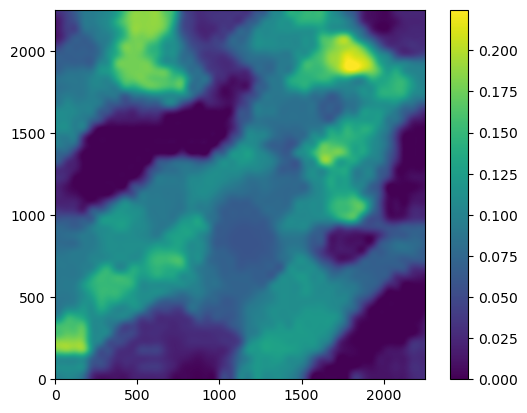

In [25]:
plt.figure()
bkg_estimator = MedianBackground()
bkg_derim = Background2D(derim, (50, 50), filter_size=(5, 5), sigma_clip = sigma_clip, bkg_estimator=bkg_estimator)
plt.imshow(bkg_derim.background, origin = 'lower', )
#plt.imshow(gaussian_filter(cirim5, 20), origin = 'lower')
plt.colorbar()
plt.show()

In [10]:
hdu = fits.open(os.path.join(path_data, 'Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.fits'))
oim, header = hdu[0].data, hdu[0].header
noise_pixels, val_max = dawis.sample_noise(oim, n_sigmas = 3, bins = 300)
hduo = fits.PrimaryHDU()
hdu_oim = fits.ImageHDU(oim, header = header, name = 'ORIGINAL')
hdu_cirim = fits.ImageHDU(cirim + val_max, header = header, name = 'CIRRUS')
hdu_derim = fits.ImageHDU(derim, header = header, name = 'RMS')
hdu_clean = fits.ImageHDU(oim - cirim, header = header, name = 'CLEANED')
hdu_recim = fits.ImageHDU(recim, header = header, name = 'RECIM')
hdu_res = fits.ImageHDU(oim - recim, header = header, name = 'RES')

hdul = fits.HDUList([hduo, hdu_oim, hdu_clean, hdu_cirim, hdu_derim, hdu_recim, hdu_res])
hdul.writeto(nfp + 'synth.cirrus_lvl5.fits', overwrite = True)

In [3]:
# rewrite input for 2nd pass
for infile in glob.glob(os.path.join(path_wavelets, 'Euclid-NISP-?-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_lvl5.fits')):
    hdu = fits.open(infile)
    res = hdu[-1].data
    hduo = fits.PrimaryHDU(res, header = hdu[-1].header)
    hduo.writeto(infile[:-9] +'res_pass1.fits', overwrite = True)

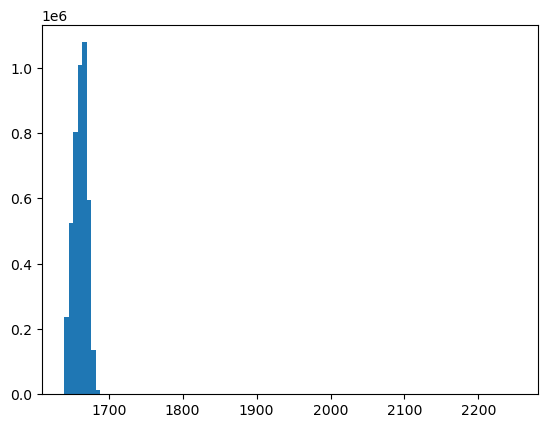

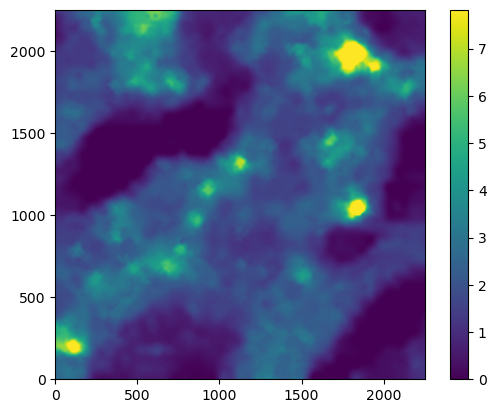

1683.5687 1660.1217033671296 21.897472159717083


In [33]:
# rewrite input for 2nd pass
for infile in glob.glob(os.path.join(path_wavelets, 'Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_lvl5.fits')):
    hduo, hdu_oim, hdu_clean, hdu_cirim, hdu_derim, hdu_recim, hdu_res = fits.open(infile)
    res = hdu_res.data
    cirim = hdu_cirim.data
    derim = hdu_derim.data
    recim = hdu_recim.data

    hdu = fits.open(os.path.join(path_data, 'Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.fits'))
    oim, header = hdu[0].data, hdu[0].header
    noise_pixels, val_max = dawis.sample_noise(oim, n_sigmas = 3, bins = 300)
    plt.figure()
    plt.hist(bkg.background.flatten(), bins = 100, range = (1640, 2250))
    plt.show()

    sigma_clip = SigmaClip(sigma = 3.0)
    bkg_estimator = MedianBackground()
    bkg = Background2D(res, (20, 20), filter_size=(3, 3), sigma_clip = sigma_clip, bkg_estimator=bkg_estimator)
    plt.figure()
    plt.imshow(bkg.background_rms * bkg_derim.background, origin = 'lower', norm = ImageNormalize( bkg.background_rms * bkg_derim.background, interval = ZScaleInterval(), stretch = LinearStretch() ) )#
    plt.colorbar()
    plt.show()
    
    #nfp = os.path.join(path_wavelets, 'Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_pass1.')

    #cirim2 = np.zeros((xs, ys))
    #derim2 = np.zeros((xs, ys))

    ## dawis 2nd pass
    #for i in range(1, 38):
    #    
    #    print(i, end = '\r')
    #    op = nfp + 'ol.it%03d.hdf5'%i
    #    with h5py.File(op, "r") as f1:
    #        if len(f1.keys()) > 100:continue
    #        for o in f1.keys():
    #            gc.collect()
    #            x_min, y_min, x_max, y_max = np.copy(f1[o]['bbox'][()])
    #            image = np.copy(f1[o]['image'][()])
    #            det_err_image = np.copy(f1[o]['det_err_image'][()])
    #            #m = detect_sources(image, threshold = 0., npixels=1)
    #            #c = SourceCatalog(image, m)
    #            #xco = int(c.centroid_quad[0][1] + x_min)
    #            #yco = int(c.centroid_quad[0][0] + y_min)
    #            #xco = np.unravel_index(image.argmax(), image.shape)[0] + x_min
    #            #yco = np.unravel_index(image.argmax(), image.shape)[1] + y_min
    #            lvlo = np.copy(f1[o]['level'][()])
    #
    #            if lvlo >= 7:
    #                cirim2[ x_min : x_max, y_min : y_max ] += image
    #                derim2[ x_min : x_max, y_min : y_max ] += det_err_image
    #print('done')

    # H it 29 A 35
    # J it 46 A 70
    # Y it 37
    # hand made last correction
    #with h5py.File(os.path.join(path_wavelets, 'Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_pass1.ol.it037.hdf5'), "r") as f1:
    #    for o in f1.keys():
    #        x_min, y_min, x_max, y_max = np.copy(f1[o]['bbox'][()])
    #        image = np.copy(f1[o]['image'][()])
    #        det_err_image = np.copy(f1[o]['det_err_image'][()])
    #        A = 60
    #        cirim2[ x_min : x_max, y_min : y_max ] += A * image
    #        derim2[ x_min : x_max, y_min : y_max ] += A * det_err_image

    # H it 48 A 20
    # J it 08 A 40
    # Y
    # hand made last correction
    #with h5py.File(os.path.join(path_wavelets, 'Euclid-NISP-J-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_pass1.ol.it008.hdf5'), "r") as f1:
    #    for o in f1.keys():
    #        x_min, y_min, x_max, y_max = np.copy(f1[o]['bbox'][()])
    #        image = np.copy(f1[o]['image'][()])
    #        det_err_image = np.copy(f1[o]['det_err_image'][()])
    #        A = 40
    #        cirim2[ x_min : x_max, y_min : y_max ] += A * image
    #        derim2[ x_min : x_max, y_min : y_max ] += A * det_err_image


    

    
    #hduo = fits.PrimaryHDU()
    #hdu_cirim = fits.ImageHDU(cirim + cirim2 - val_max, header = header, name = 'CIRRUS')
    #hdu_derim = fits.ImageHDU(derim + derim2, header = header, name = 'RMS')
    #hdu_clean = fits.ImageHDU(oim - cirim + val_max - cirim2, header = header, name = 'CLEANED')
    #hdu_recim = fits.ImageHDU(recim + cirim2, header = header, name = 'RECIM')
    #hdu_res = fits.ImageHDU(oim - recim - cirim2, header = header, name = 'RES')    
    
    #hdul = fits.HDUList([hduo, hdu_oim, hdu_clean, hdu_cirim, hdu_derim, hdu_recim, hdu_res])
    #hdul.writeto(os.path.join(path_wavelets, 'Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_pass2.fits'), overwrite = True)

    print(val_max, bkg.background_median, bkg.background_rms_median)
    #>>>>>hduo = fits.PrimaryHDU()
    #>>>>>hdu_cirim = fits.ImageHDU(cirim + bkg.background - val_max, header = header, name = 'CIRRUS')
    #>>>>>hdu_clean = fits.ImageHDU(oim - cirim + val_max - bkg.background, header = header, name = 'CLEANED')
    #>>>>>hdu_recim = fits.ImageHDU(recim + bkg.background - val_max, header = header, name = 'RECIM')
    #>>>>>hdu_res = fits.ImageHDU(oim - recim - bkg.background + val_max, header = header, name = 'RES')    
    #>>>>>
    #>>>>>hdul = fits.HDUList([hduo, hdu_oim, hdu_clean, hdu_cirim, hdu_recim, hdu_res])
    #>>>>>hdul.writeto(os.path.join(path_wavelets, 'Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_altpass2.fits'), overwrite = True)
    


In [21]:
os.path.join(path_wavelets, 'Euclid-NISP-?-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_pass2.fits')[52]

'?'

In [83]:
# Resize to original size and rotate to original orientation
for infile in glob.glob(os.path.join(path_wavelets, 'Euclid-NISP-?-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_altpass2.fits')):
    
    print(infile)
    filt = infile[52]
    hdu = fits.open(infile)
    cirim, header = hdu[3].data, hdu[3].header

    # original pixel size
    warp = os.path.join(path_wavelets, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.rot.crop.synth.cirrus.bkg_sub.fits'%filt)
    subprocess.run(['astwarp', '--scale=4.', '-h3', '--output=%s'%warp, infile])

    # rot
    rot = os.path.join(path_wavelets, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.crop.synth.cirrus.bkg_sub.fits'%filt)
    subprocess.run(['astwarp', '--rotate=-295', '-h1', warp, '--output=%s'%rot])

print('done')

/home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_altpass2.fits
Warp 0.21 started on Mon Jul 22 16:01:13 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_altpass2.fits (hdu: 3)
 matrix:
	 4.0000    0.0000    0.0000
	 0.0000    4.0000    0.0000
	 0.0000    0.0000    1.0000


astwarp: gal_fits_key_write_filename: WARNING: the filename '/home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_altpass2.fits' (not including directories) is too long to fit into a FITS keyword value (max of 68 characters). It will therefore be truncated. If you are using Gnuastro's programs, this message is only about the metadata (keyword that keeps name of input), so it won't affect the output analysis and data. In this case, you can suppress this warning message with a '--quiet' option
astwarp: gal_fits_key_write_filename: WARNING: the filename '/home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_altpass2.fits' (not including directories) is too long to fit into a FITS keyword value (max of 68 characters). It will therefore be truncated. If you are using Gnuastro's programs, this message is only about the metadata (keyword that keeps name of input), so it won't

 Output: /home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.rot.crop.synth.cirrus.bkg_sub.fits
Warp finished in:  2.183872 seconds
Warp 0.21 started on Mon Jul 22 16:01:15 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.rot.crop.synth.cirrus.bkg_sub.fits (hdu: 1)
 matrix:
	 0.4226   -0.9063    0.0000
	 0.9063    0.4226    0.0000
	 0.0000    0.0000    1.0000


astwarp: gal_fits_key_write_filename: WARNING: the filename '/home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.rot.crop.synth.cirrus.bkg_sub.fits' (not including directories) is too long to fit into a FITS keyword value (max of 68 characters). It will therefore be truncated. If you are using Gnuastro's programs, this message is only about the metadata (keyword that keeps name of input), so it won't affect the output analysis and data. In this case, you can suppress this warning message with a '--quiet' option
astwarp: gal_fits_key_write_filename: WARNING: the filename '/home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.rot.crop.synth.cirrus.bkg_sub.fits' (not including directories) is too long to fit into a FITS keyword value (max of 68 characters). It will therefore be truncated. If you are using Gnuastro's programs, this message is only about the metadata (keyword that keeps name of input), so it won't affect the output analysis and 

 Output: /home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.crop.synth.cirrus.bkg_sub.fits
Warp finished in:  7.045177 seconds
/home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_altpass2.fits
Warp 0.21 started on Mon Jul 22 16:01:22 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_altpass2.fits (hdu: 3)
 matrix:
	 4.0000    0.0000    0.0000
	 0.0000    4.0000    0.0000
	 0.0000    0.0000    1.0000


astwarp: gal_fits_key_write_filename: WARNING: the filename '/home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_altpass2.fits' (not including directories) is too long to fit into a FITS keyword value (max of 68 characters). It will therefore be truncated. If you are using Gnuastro's programs, this message is only about the metadata (keyword that keeps name of input), so it won't affect the output analysis and data. In this case, you can suppress this warning message with a '--quiet' option
astwarp: gal_fits_key_write_filename: WARNING: the filename '/home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_altpass2.fits' (not including directories) is too long to fit into a FITS keyword value (max of 68 characters). It will therefore be truncated. If you are using Gnuastro's programs, this message is only about the metadata (keyword that keeps name of input), so it won't

 Output: /home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.synth.cirrus.bkg_sub.fits
Warp finished in:  2.394742 seconds


astwarp: gal_fits_key_write_filename: WARNING: the filename '/home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.synth.cirrus.bkg_sub.fits' (not including directories) is too long to fit into a FITS keyword value (max of 68 characters). It will therefore be truncated. If you are using Gnuastro's programs, this message is only about the metadata (keyword that keeps name of input), so it won't affect the output analysis and data. In this case, you can suppress this warning message with a '--quiet' option


Warp 0.21 started on Mon Jul 22 16:01:25 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.synth.cirrus.bkg_sub.fits (hdu: 1)
 matrix:
	 0.4226   -0.9063    0.0000
	 0.9063    0.4226    0.0000
	 0.0000    0.0000    1.0000


astwarp: gal_fits_key_write_filename: WARNING: the filename '/home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.synth.cirrus.bkg_sub.fits' (not including directories) is too long to fit into a FITS keyword value (max of 68 characters). It will therefore be truncated. If you are using Gnuastro's programs, this message is only about the metadata (keyword that keeps name of input), so it won't affect the output analysis and data. In this case, you can suppress this warning message with a '--quiet' option


 Output: /home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.crop.synth.cirrus.bkg_sub.fits
Warp finished in:  7.196673 seconds
/home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_altpass2.fits
Warp 0.21 started on Mon Jul 22 16:01:32 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_altpass2.fits (hdu: 3)
 matrix:
	 4.0000    0.0000    0.0000
	 0.0000    4.0000    0.0000
	 0.0000    0.0000    1.0000


astwarp: gal_fits_key_write_filename: WARNING: the filename '/home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_altpass2.fits' (not including directories) is too long to fit into a FITS keyword value (max of 68 characters). It will therefore be truncated. If you are using Gnuastro's programs, this message is only about the metadata (keyword that keeps name of input), so it won't affect the output analysis and data. In this case, you can suppress this warning message with a '--quiet' option
astwarp: gal_fits_key_write_filename: WARNING: the filename '/home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_altpass2.fits' (not including directories) is too long to fit into a FITS keyword value (max of 68 characters). It will therefore be truncated. If you are using Gnuastro's programs, this message is only about the metadata (keyword that keeps name of input), so it won't

 Output: /home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.rot.crop.synth.cirrus.bkg_sub.fits
Warp finished in:  2.286367 seconds
Warp 0.21 started on Mon Jul 22 16:01:34 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.rot.crop.synth.cirrus.bkg_sub.fits (hdu: 1)
 matrix:
	 0.4226   -0.9063    0.0000
	 0.9063    0.4226    0.0000
	 0.0000    0.0000    1.0000


astwarp: gal_fits_key_write_filename: WARNING: the filename '/home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.rot.crop.synth.cirrus.bkg_sub.fits' (not including directories) is too long to fit into a FITS keyword value (max of 68 characters). It will therefore be truncated. If you are using Gnuastro's programs, this message is only about the metadata (keyword that keeps name of input), so it won't affect the output analysis and data. In this case, you can suppress this warning message with a '--quiet' option
astwarp: gal_fits_key_write_filename: WARNING: the filename '/home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.rot.crop.synth.cirrus.bkg_sub.fits' (not including directories) is too long to fit into a FITS keyword value (max of 68 characters). It will therefore be truncated. If you are using Gnuastro's programs, this message is only about the metadata (keyword that keeps name of input), so it won't affect the output analysis and 

 Output: /home/aellien/Euclid_ERO/wavelets/out11/Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.crop.synth.cirrus.bkg_sub.fits
Warp finished in:  7.525675 seconds
done


In [86]:
os.path.join(path_data, 'Euclid-NISP-?-ERO-Abell2390-LSB.DR3.fits')[-28]

'?'

In [88]:
# Make original image with same size as cirim
for infile in glob.glob(os.path.join(path_data, 'Euclid-NISP-?-ERO-Abell2390-LSB.DR3.fits')):
    
    print(infile)
    filt = infile[-28]
    hdu = fits.open(os.path.join(path_data, infile))
    oim, header = hdu[0].data, hdu[0].header

    # rot
    rot = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.rot.fits'%filt)
    subprocess.run(['astwarp', '--rotate=295', '-h0', infile, '--output=%s'%rot])

    # crop
    crop = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.rot.crop.fits'%filt)
    subprocess.run(['astcrop', '--mode=wcs', '--center=328.40009,17.699051', '--width=0.75,0.75', '-h1', '--output=%s'%crop, rot])

    # reverse rot
    revrot = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.revrot.fits'%filt)
    subprocess.run(['astwarp', '--rotate=-295', '-h1', crop, '--output=%s'%revrot])

print('done')

/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.fits
Warp 0.21 started on Mon Jul 22 16:03:19 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.fits (hdu: 0)
 matrix:
	 0.4226    0.9063    0.0000
	-0.9063    0.4226    0.0000
	 0.0000    0.0000    1.0000
 Output: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.fits
Warp finished in:  19.090731 seconds
Crop 0.21 started on Mon Jul 22 16:03:38 2024
  - Read metadata of 1 dataset.                        0.001007 seconds
  ---- ...l2390-LSB.DR3.rot.crop.fits created: 1 input.
Crop finished in:  1.377631 seconds
Warp 0.21 started on Mon Jul 22 16:03:39 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.fits (hdu: 1)
 matrix:
	 0.4226   -0.9063    0.00

In [90]:
# Final product for public
for infile in glob.glob(os.path.join(path_data, 'Euclid-NISP-?-ERO-Abell2390-LSB.DR3.revrot.fits')):
    filt = infile[-35]
    hdu = fits.open(infile)
    oim, header = hdu[1].data[:11962, :11962], hdu[1].header
    #noise_pixels, val_max = dawis.sample_noise(oim, n_sigmas = 3, bins = 300)

    cirim = fits.getdata(os.path.join(path_wavelets, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.crop.synth.cirrus.bkg_sub.fits'%filt))[:11962, :11962]
    
    hduo = fits.PrimaryHDU()
    hdu_oim = fits.ImageHDU(oim, header = header, name = 'ORIGINAL')
    hdu_clean = fits.ImageHDU(oim - cirim, header = header, name = 'CLEANED BKG-SUBTR.')
    hdu_cirim = fits.ImageHDU(cirim, header = header, name = 'CIRRUS+BKG')
    #hdu_derim = fits.ImageHDU(derim, header = header, name = 'RMS')
    
    hdul = fits.HDUList([hduo, hdu_oim, hdu_clean, hdu_cirim ])
    hdul.writeto(os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.crop.synth.cirrus_lvl5.bkg_sub.fits'%filt), overwrite = True)

In [92]:
# Input for DAWIS
for infile in glob.glob(os.path.join(path_data, 'Euclid-NISP-?-ERO-Abell2390-LSB.DR3.crop.synth.cirrus_lvl5.bkg_sub.fits.gz')):
    filt = infile[-62]
    
    # crop
    crop = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.crop.synth.cirrus_lvl5.crop.fits'%filt)
    subprocess.run(['astcrop', '--mode=wcs', '--center=328.40009,17.699051', '--width=0.3,0.3', '-h2', '--output=%s'%crop, infile])

    # dawis input rdy
    input = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.crop.synth.cirrus_lvl5.bkg_sub.input.fits'%filt)
    subprocess.run(['astfits', crop, '--copy=1', '--output=%s'%input, '--primaryimghdu'])

Crop 0.21 started on Mon Jul 22 16:38:47 2024
  - Read metadata of 1 dataset.                        13.855915 seconds
  ---- ...synth.cirrus_lvl5.crop.fits created: 1 input.
Crop finished in:  20.982186 seconds


astcrop: gal_fits_key_write_filename: WARNING: the filename '/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.crop.synth.cirrus_lvl5.bkg_sub.fits.gz' (not including directories) is too long to fit into a FITS keyword value (max of 68 characters). It will therefore be truncated. If you are using Gnuastro's programs, this message is only about the metadata (keyword that keeps name of input), so it won't affect the output analysis and data. In this case, you can suppress this warning message with a '--quiet' option


Crop 0.21 started on Mon Jul 22 16:39:08 2024
  - Read metadata of 1 dataset.                        13.836033 seconds
  ---- ...synth.cirrus_lvl5.crop.fits created: 1 input.
Crop finished in:  21.006278 seconds


astcrop: gal_fits_key_write_filename: WARNING: the filename '/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.crop.synth.cirrus_lvl5.bkg_sub.fits.gz' (not including directories) is too long to fit into a FITS keyword value (max of 68 characters). It will therefore be truncated. If you are using Gnuastro's programs, this message is only about the metadata (keyword that keeps name of input), so it won't affect the output analysis and data. In this case, you can suppress this warning message with a '--quiet' option


Crop 0.21 started on Mon Jul 22 16:39:29 2024
  - Read metadata of 1 dataset.                        13.972175 seconds
  ---- ...synth.cirrus_lvl5.crop.fits created: 1 input.
Crop finished in:  21.184286 seconds


astcrop: gal_fits_key_write_filename: WARNING: the filename '/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.crop.synth.cirrus_lvl5.bkg_sub.fits.gz' (not including directories) is too long to fit into a FITS keyword value (max of 68 characters). It will therefore be truncated. If you are using Gnuastro's programs, this message is only about the metadata (keyword that keeps name of input), so it won't affect the output analysis and data. In this case, you can suppress this warning message with a '--quiet' option


In [5]:
# cirrus crop at cluster size
for infile in glob.glob(os.path.join(path_data, 'Euclid-NISP-?-ERO-Abell2390-LSB.DR3.crop.synth.cirrus_lvl5.bkg_sub.fits.gz')):
    filt = infile[-62]
    
    # crop
    crop = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.crop.synth.cirrus_lvl5.crop.fits'%filt)
    subprocess.run(['astcrop', '--mode=wcs', '--center=328.40009,17.699051', '--width=0.3,0.3', '-h3', '--output=%s'%crop, infile])

Crop 0.21 started on Mon Jul 29 09:43:25 2024
  - Read metadata of 1 dataset.                        13.949293 seconds
  ---- ...synth.cirrus_lvl5.crop.fits created: 1 input.
Crop finished in:  21.092575 seconds


astcrop: gal_fits_key_write_filename: WARNING: the filename '/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.crop.synth.cirrus_lvl5.bkg_sub.fits.gz' (not including directories) is too long to fit into a FITS keyword value (max of 68 characters). It will therefore be truncated. If you are using Gnuastro's programs, this message is only about the metadata (keyword that keeps name of input), so it won't affect the output analysis and data. In this case, you can suppress this warning message with a '--quiet' option


Crop 0.21 started on Mon Jul 29 09:43:46 2024
  - Read metadata of 1 dataset.                        13.899599 seconds
  ---- ...synth.cirrus_lvl5.crop.fits created: 1 input.
Crop finished in:  21.030354 seconds


astcrop: gal_fits_key_write_filename: WARNING: the filename '/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.crop.synth.cirrus_lvl5.bkg_sub.fits.gz' (not including directories) is too long to fit into a FITS keyword value (max of 68 characters). It will therefore be truncated. If you are using Gnuastro's programs, this message is only about the metadata (keyword that keeps name of input), so it won't affect the output analysis and data. In this case, you can suppress this warning message with a '--quiet' option


Crop 0.21 started on Mon Jul 29 09:44:07 2024
  - Read metadata of 1 dataset.                        13.933416 seconds
  ---- ...synth.cirrus_lvl5.crop.fits created: 1 input.
Crop finished in:  21.082107 seconds


astcrop: gal_fits_key_write_filename: WARNING: the filename '/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.crop.synth.cirrus_lvl5.bkg_sub.fits.gz' (not including directories) is too long to fit into a FITS keyword value (max of 68 characters). It will therefore be truncated. If you are using Gnuastro's programs, this message is only about the metadata (keyword that keeps name of input), so it won't affect the output analysis and data. In this case, you can suppress this warning message with a '--quiet' option


In [93]:
infile[-62]

'J'

In [35]:
cirim.shape

(2251, 2251)